# Multi Features CNN-LSTM Model

The model I created is a multi-feature CNN-LSTM designed to predict weekly movements in the price of steel

## Libraries

In [102]:
from pathlib import Path

import yfinance as yf
import numpy as np
import pandas as pd
import math
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, InputLayer

import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [104]:
target_ticker = 'HRC=F'

tickers = ([target_ticker, 'HG=F', 'GC=F', 'CL=F', '^DJI', 'SHV'])
start_date = '2008-11-01'
end_date = '2023-11-01'

In [105]:
raw_data = yf.download(tickers=tickers, start=start_date, end=end_date)
raw_data = raw_data['Close'].copy()
raw_data = raw_data.resample('w').mean()

df = raw_data.copy()

for col in df.columns:
    df[col] = df[col].pct_change()

df.dropna(inplace=True)
print(df.shape)
df.head()

[*********************100%%**********************]  6 of 6 completed
(782, 6)


,CL=F,GC=F,HG=F,HRC=F,SHV,^DJI
Date,,,,,,
2008-11-16,-0.088229,-0.012069,-0.073468,0.000000,0.001124,-0.055644
2008-11-23,-0.104612,0.029677,-0.037882,0.000000,0.000525,-0.066823
2008-11-30,0.019675,0.087297,0.026855,-0.024000,0.000539,0.069583
2008-12-07,-0.150051,-0.058636,-0.088665,-0.032787,0.000466,-0.021500
2008-12-14,-0.017362,0.039516,-0.034762,-0.062712,0.000471,0.033439


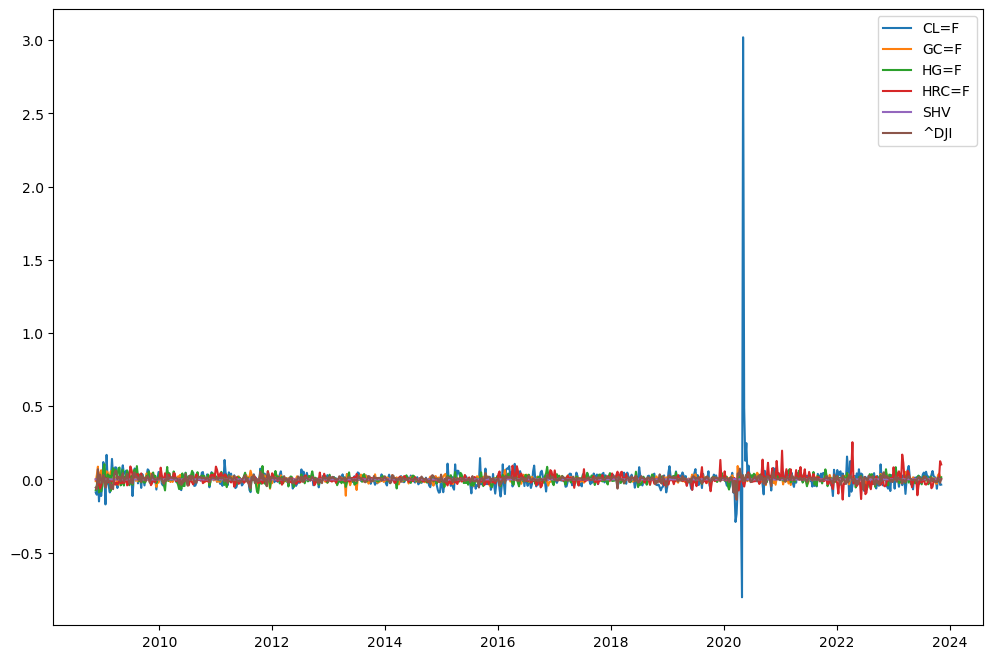

In [106]:
plt.figure(figsize=(12,8))

for col in df.columns:
    name = col
    plt.plot(df[col], label=name)

plt.legend(loc='best')
plt.show()

In [107]:
def create_multifeature_data(df, window_size):
    y = df[window_size:]
    y = y[target_ticker]
    n = df.shape[0]
    X = np.stack([df[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [108]:
window_size = 16

In [109]:
X, y = create_multifeature_data(df=df, window_size=window_size)
X.shape, y.shape

((766, 16, 6), (766,))

In [110]:
n_obs, window_size, n_features = X.shape

In [111]:
#split data
train_size = 348
val_size = 348+158

In [112]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size+1], y[train_size:val_size+1]
X_test, y_test = X[val_size+1:], y[val_size+1:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((348, 16, 6), (348,), (159, 16, 6), (159,), (259, 16, 6), (259,))

## Model Building

In [113]:
architecture = Sequential()
architecture.add(InputLayer((window_size, n_features)))
architecture.add(Conv1D(50, kernel_size=5, activation='tanh', padding='same'))
architecture.add(LSTM(50, activation='tanh'))
architecture.add(Dense(10, activation='tanh'))
architecture.add(Dense(1, 'linear'))
architecture.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 16, 50)            1550      
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 22271 (87.00 KB)
Trainable params: 22271 (87.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
optimizer = tf.keras.optimizers.legacy.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    epsilon=1e-08,
    decay=0.0
)

In [115]:
architecture.compile(loss='mean_squared_error', 
            optimizer=optimizer)

In [116]:
path = Path("Model")

cnn_lstm_path = (path / 'cnn_lstm_model').as_posix()
checkpointer = ModelCheckpoint(filepath=cnn_lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=40,
                              restore_best_weights=True)

In [118]:
model_training = architecture.fit(X_train,
                        y_train,
                        epochs=150,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150


 8/11 [====================>.........] - ETA: 0s - loss: 8.5846e-04 
Epoch 1: val_loss improved from inf to 0.00046, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 8s 532ms/step - loss: 7.0857e-04 - val_loss: 4.5845e-04
Epoch 2/150
 7/11 [==================>...........] - ETA: 0s - loss: 2.8056e-04
Epoch 2: val_loss improved from 0.00046 to 0.00042, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 417ms/step - loss: 3.1536e-04 - val_loss: 4.2486e-04
Epoch 3/150
 7/11 [==================>...........] - ETA: 0s - loss: 2.9637e-04
Epoch 3: val_loss improved from 0.00042 to 0.00042, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 373ms/step - loss: 3.1895e-04 - val_loss: 4.1996e-04
Epoch 4/150
10/11 [==========================>...] - ETA: 0s - loss: 3.5915e-04
Epoch 4: val_loss did not improve from 0.00042
11/11 [==============================] - 0s 10ms/step - loss: 3.5118e-04 - val_loss: 4.5424e-04
Epoch 5/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.6032e-04
Epoch 5: val_loss did not improve from 0.00042
11/11 [==============================] - 0s 11ms/step - loss: 3.0377e-04 - val_loss: 6.7400e-04
Epoch 6/150
10/11 [==========================>...] - ETA: 0s - loss: 2.9222e-04
Epoch 6: val_loss improved from 0.00042 to 0.00041, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 361ms/step - loss: 2.9913e-04 - val_loss: 4.1153e-04
Epoch 7/150
 7/11 [==================>...........] - ETA: 0s - loss: 3.6504e-04
Epoch 7: val_loss did not improve from 0.00041
11/11 [==============================] - 0s 16ms/step - loss: 3.0434e-04 - val_loss: 4.2869e-04
Epoch 8/150
 7/11 [==================>...........] - ETA: 0s - loss: 3.1554e-04
Epoch 8: val_loss did not improve from 0.00041
11/11 [==============================] - 0s 14ms/step - loss: 3.1451e-04 - val_loss: 5.8707e-04
Epoch 9/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.7429e-04
Epoch 9: val_loss did not improve from 0.00041
11/11 [==============================] - 0s 13ms/step - loss: 2.9357e-04 - val_loss: 4.2449e-04
Epoch 10/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.7327e-04
Epoch 10: val_loss improved from 0.00041 to 0.00040, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 379ms/step - loss: 2.8129e-04 - val_loss: 3.9830e-04
Epoch 11/150
10/11 [==========================>...] - ETA: 0s - loss: 2.8682e-04
Epoch 11: val_loss did not improve from 0.00040
11/11 [==============================] - 0s 11ms/step - loss: 2.9066e-04 - val_loss: 5.1213e-04
Epoch 12/150
10/11 [==========================>...] - ETA: 0s - loss: 2.7987e-04
Epoch 12: val_loss did not improve from 0.00040
11/11 [==============================] - 0s 10ms/step - loss: 2.8643e-04 - val_loss: 4.0030e-04
Epoch 13/150
10/11 [==========================>...] - ETA: 0s - loss: 2.9504e-04
Epoch 13: val_loss did not improve from 0.00040
11/11 [==============================] - 0s 10ms/step - loss: 2.8415e-04 - val_loss: 4.1090e-04
Epoch 14/150
10/11 [==========================>...] - ETA: 0s - loss: 2.7741e-04
Epoch 14: val_loss did not improve from 0.00040
11/11 [==============================] - 0s 10ms/step - loss: 2.7920e-04 - val_loss: 4.2991e-04
Epo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 427ms/step - loss: 3.1136e-04 - val_loss: 3.9528e-04
Epoch 16/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.3718e-04
Epoch 16: val_loss did not improve from 0.00040
11/11 [==============================] - 0s 11ms/step - loss: 2.5173e-04 - val_loss: 4.6823e-04
Epoch 17/150
10/11 [==========================>...] - ETA: 0s - loss: 3.0031e-04
Epoch 17: val_loss did not improve from 0.00040
11/11 [==============================] - 0s 11ms/step - loss: 2.9728e-04 - val_loss: 3.9591e-04
Epoch 18/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.9147e-04
Epoch 18: val_loss improved from 0.00040 to 0.00039, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 353ms/step - loss: 2.7699e-04 - val_loss: 3.8592e-04
Epoch 19/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.1001e-04
Epoch 19: val_loss did not improve from 0.00039
11/11 [==============================] - 0s 11ms/step - loss: 2.5580e-04 - val_loss: 3.9179e-04
Epoch 20/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.7437e-04
Epoch 20: val_loss did not improve from 0.00039
11/11 [==============================] - 0s 11ms/step - loss: 2.8389e-04 - val_loss: 4.1170e-04
Epoch 21/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.7802e-04
Epoch 21: val_loss did not improve from 0.00039
11/11 [==============================] - 0s 11ms/step - loss: 2.6805e-04 - val_loss: 4.2664e-04
Epoch 22/150
10/11 [==========================>...] - ETA: 0s - loss: 2.4809e-04
Epoch 22: val_loss improved from 0.00039 to 0.00038, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:ten

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 343ms/step - loss: 2.6006e-04 - val_loss: 3.7819e-04
Epoch 23/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.4813e-04
Epoch 23: val_loss did not improve from 0.00038
11/11 [==============================] - 0s 11ms/step - loss: 2.6289e-04 - val_loss: 3.8218e-04
Epoch 24/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.6221e-04
Epoch 24: val_loss did not improve from 0.00038
11/11 [==============================] - 0s 11ms/step - loss: 2.7603e-04 - val_loss: 3.8865e-04
Epoch 25/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.6540e-04
Epoch 25: val_loss improved from 0.00038 to 0.00038, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 325ms/step - loss: 2.5378e-04 - val_loss: 3.7703e-04
Epoch 26/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.3231e-04
Epoch 26: val_loss did not improve from 0.00038
11/11 [==============================] - 0s 11ms/step - loss: 2.5439e-04 - val_loss: 3.9790e-04
Epoch 27/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.4816e-04
Epoch 27: val_loss did not improve from 0.00038
11/11 [==============================] - 0s 12ms/step - loss: 2.3671e-04 - val_loss: 3.9759e-04
Epoch 28/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.7590e-04
Epoch 28: val_loss did not improve from 0.00038
11/11 [==============================] - 0s 11ms/step - loss: 2.6075e-04 - val_loss: 4.1059e-04
Epoch 29/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.6202e-04
Epoch 29: val_loss did not improve from 0.00038
11/11 [==============================] - 0s 11ms/step - loss: 2.5169e-04 - val_loss: 4.4921e-04
Epo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 385ms/step - loss: 2.4893e-04 - val_loss: 3.7191e-04
Epoch 32/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.4793e-04
Epoch 32: val_loss improved from 0.00037 to 0.00037, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 337ms/step - loss: 2.3710e-04 - val_loss: 3.7117e-04
Epoch 33/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.3654e-04
Epoch 33: val_loss improved from 0.00037 to 0.00037, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 322ms/step - loss: 2.5730e-04 - val_loss: 3.6766e-04
Epoch 34/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.5009e-04
Epoch 34: val_loss did not improve from 0.00037
11/11 [==============================] - 0s 11ms/step - loss: 2.3212e-04 - val_loss: 4.0339e-04
Epoch 35/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.0558e-04
Epoch 35: val_loss did not improve from 0.00037
11/11 [==============================] - 0s 11ms/step - loss: 2.3923e-04 - val_loss: 3.9482e-04
Epoch 36/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.0790e-04
Epoch 36: val_loss did not improve from 0.00037
11/11 [==============================] - 0s 11ms/step - loss: 2.4370e-04 - val_loss: 3.7730e-04
Epoch 37/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.5491e-04
Epoch 37: val_loss did not improve from 0.00037
11/11 [==============================] - 0s 11ms/step - loss: 2.5020e-04 - val_loss: 4.1132e-04
Epo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 364ms/step - loss: 2.4907e-04 - val_loss: 3.6338e-04
Epoch 41/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.1249e-04
Epoch 41: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 12ms/step - loss: 2.2728e-04 - val_loss: 4.4006e-04
Epoch 42/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.3805e-04
Epoch 42: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.5166e-04 - val_loss: 3.6795e-04
Epoch 43/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.4237e-04
Epoch 43: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.3134e-04 - val_loss: 3.7003e-04
Epoch 44/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.5541e-04
Epoch 44: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.3836e-04 - val_loss: 3.7782e-04
Epo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 322ms/step - loss: 2.2400e-04 - val_loss: 3.6331e-04
Epoch 63/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.3727e-04
Epoch 63: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.2673e-04 - val_loss: 4.0547e-04
Epoch 64/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.2658e-04
Epoch 64: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.1375e-04 - val_loss: 3.8287e-04
Epoch 65/150
 9/11 [=======================>......] - ETA: 0s - loss: 1.9060e-04
Epoch 65: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.2414e-04 - val_loss: 3.7308e-04
Epoch 66/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.2366e-04
Epoch 66: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.1898e-04 - val_loss: 4.2683e-04
Epo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 4s 440ms/step - loss: 2.2963e-04 - val_loss: 3.6011e-04
Epoch 68/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.0211e-04
Epoch 68: val_loss improved from 0.00036 to 0.00036, saving model to C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1
INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 334ms/step - loss: 2.0779e-04 - val_loss: 3.5869e-04
Epoch 69/150
 9/11 [=======================>......] - ETA: 0s - loss: 2.4216e-04
Epoch 69: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.3508e-04 - val_loss: 3.6906e-04
Epoch 70/150
 9/11 [=======================>......] - ETA: 0s - loss: 1.9806e-04
Epoch 70: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.0256e-04 - val_loss: 3.7297e-04
Epoch 71/150
10/11 [==========================>...] - ETA: 0s - loss: 2.1023e-04
Epoch 71: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.0494e-04 - val_loss: 3.5923e-04
Epoch 72/150
 9/11 [=======================>......] - ETA: 0s - loss: 1.9103e-04
Epoch 72: val_loss did not improve from 0.00036
11/11 [==============================] - 0s 11ms/step - loss: 2.0634e-04 - val_loss: 3.8311e-04
Epo

INFO:tensorflow:Assets written to: C:/Users/Mio/OneDrive/Code_files/University_Thesis/Model\multi_test_1\assets


11/11 [==============================] - 3s 335ms/step - loss: 1.8532e-04 - val_loss: 3.5226e-04
Epoch 93/150
 8/11 [====================>.........] - ETA: 0s - loss: 2.2840e-04
Epoch 93: val_loss did not improve from 0.00035
11/11 [==============================] - 0s 11ms/step - loss: 2.0564e-04 - val_loss: 3.9433e-04
Epoch 94/150
 9/11 [=======================>......] - ETA: 0s - loss: 1.7749e-04
Epoch 94: val_loss did not improve from 0.00035
11/11 [==============================] - 0s 11ms/step - loss: 1.8411e-04 - val_loss: 3.5769e-04
Epoch 95/150
 9/11 [=======================>......] - ETA: 0s - loss: 1.9531e-04
Epoch 95: val_loss did not improve from 0.00035
11/11 [==============================] - 0s 12ms/step - loss: 1.9966e-04 - val_loss: 3.7909e-04
Epoch 96/150
 9/11 [=======================>......] - ETA: 0s - loss: 1.9598e-04
Epoch 96: val_loss did not improve from 0.00035
11/11 [==============================] - 0s 11ms/step - loss: 2.0309e-04 - val_loss: 3.6724e-04
Epo

## Evaluation Metrics

In [119]:
model = load_model('Model/cnn_lstm_model')

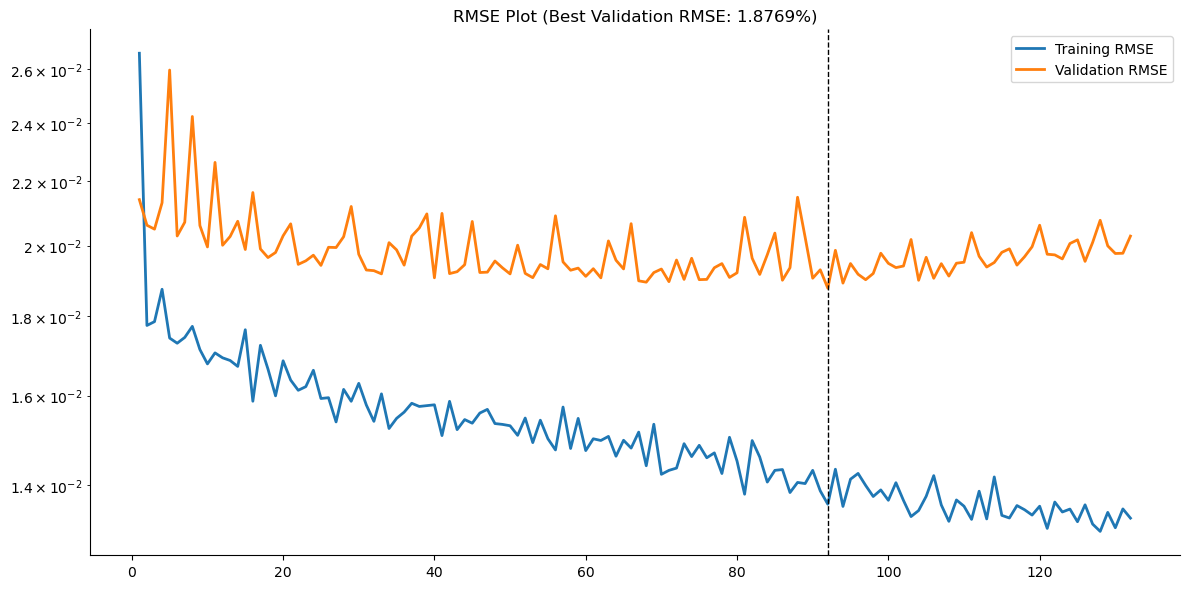

In [120]:
fig, ax = plt.subplots(figsize=(12, 6))

loss_history = pd.DataFrame(model_training.history).pow(0.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE Plot (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [121]:
train_rmse_scaled = np.sqrt(architecture.evaluate(X_train, y_train, verbose=0))
val_rmse_scaled = np.sqrt(architecture.evaluate(X_val, y_val, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {val_rmse_scaled:.4f}')

Train RMSE: 0.0135 | Test RMSE: 0.0188


## Performance Evaluation

### Train Performance

In [122]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(y_train)
train_results['Train Predictions'] = train_predictions
train_results.rename(columns={target_ticker: 'Actuals'}, 
                     inplace=True)
train_results['trend'] = (np.sign(train_results['Train Predictions']) == np.
                          sign(train_results['Actuals'])).astype(int)

train_results

11/11 [==============================] - 1s 3ms/step


,Actuals,Train Predictions,trend
Date,,,
2009-03-08,-0.001713,-0.008858,1
2009-03-15,-0.005248,0.003105,0
2009-03-22,-0.036120,-0.020663,1
2009-03-29,-0.023684,-0.021810,1
2009-04-05,-0.033962,-0.016245,1
...,...,...,...
2015-10-04,-0.038014,-0.026434,1
2015-10-11,-0.027429,-0.024330,1
2015-10-18,-0.001912,-0.011412,1


In [123]:
def synthesis(results_dataset):
    
    success_rate = round((results_dataset.iloc[:,2].sum()/
                          (results_dataset.iloc[:,0] != 0).sum())*100,2)
    root_mse = round(math.sqrt(mean_squared_error(results_dataset.iloc[:,0], 
                                                  results_dataset.iloc[:,1])),4)
    
    plt.figure(figsize=(12,8))
    plt.plot(results_dataset.iloc[:,0])
    plt.plot(results_dataset.iloc[:,1])
    plt.title(f'RMSE: {root_mse}, Success Rate: {success_rate}%')
    plt.legend(['Actuals', 'Predictions'])
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

    
    print(f'Prediction Success Rate of: {success_rate}%')
    print(f'RMSE: {root_mse}')
    

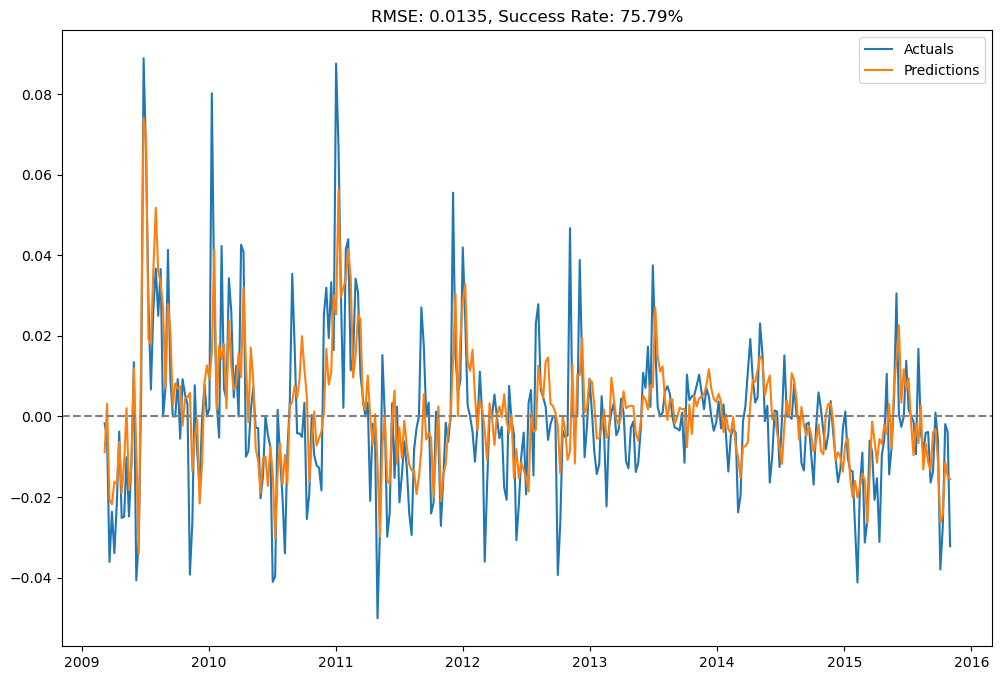

Prediction Success Rate of: 75.79%
RMSE: 0.0135


In [124]:
synthesis(train_results)

### Validation Performance

In [125]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(y_val)
val_results['Val Predictions'] = val_predictions
val_results.rename(columns={target_ticker: 'Actuals'}, 
                     inplace=True)
val_results['trend'] = (np.sign(val_results['Val Predictions']) == np.
                          sign(val_results['Actuals'])).astype(int)

val_results

5/5 [==============================] - 0s 5ms/step


,Actuals,Val Predictions,trend
Date,,,
2015-11-08,-0.019871,-0.019678,1
2015-11-15,-0.014698,0.004221,0
2015-11-22,-0.005144,0.006386,0
2015-11-29,-0.020165,-0.000447,1
2015-12-06,-0.010026,-0.014401,1
...,...,...,...
2018-10-21,-0.003373,0.010292,0
2018-10-28,0.004351,-0.004015,0
2018-11-04,0.000602,-0.005740,0


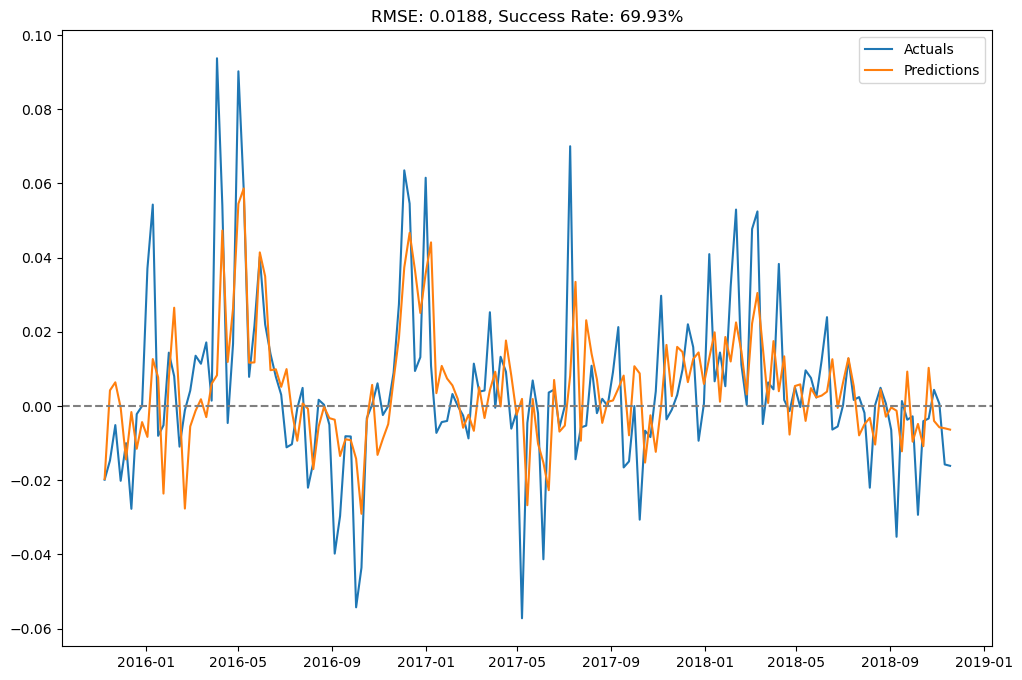

Prediction Success Rate of: 69.93%
RMSE: 0.0188


In [126]:
synthesis(val_results)

### Test Performance

In [127]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(y_test)
test_results['Test Predictions'] = test_predictions
test_results.rename(columns={target_ticker: 'Actuals'}, 
                     inplace=True)
test_results['trend'] = (np.sign(test_results['Test Predictions']) == np.
                          sign(test_results['Actuals'])).astype(int)

test_results

9/9 [==============================] - 0s 3ms/step


,Actuals,Test Predictions,trend
Date,,,
2018-11-25,-0.009252,-0.002925,1
2018-12-02,0.000815,-0.006571,0
2018-12-09,-0.038702,-0.011768,1
2018-12-16,-0.012899,-0.022711,1
2018-12-23,-0.008448,-0.002082,1
...,...,...,...
2023-10-08,-0.015828,-0.002281,1
2023-10-15,0.003159,-0.002356,0
2023-10-22,0.005726,0.005748,1


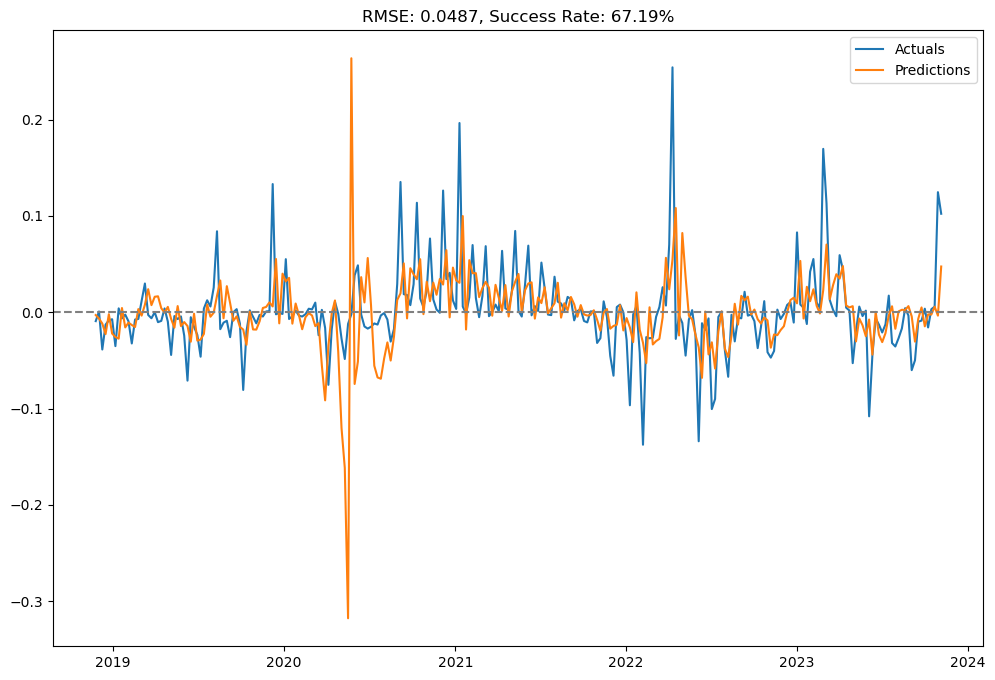

Prediction Success Rate of: 67.19%
RMSE: 0.0487


In [128]:
synthesis(test_results)

## Experiment

In this section, I conduct a simple experiment in a two-weekly purchase scenario based on the model output. The remaining experiments in the study are not included in this code, as they were carried out on output data exported to CSV files

In [129]:
test_results_1 = test_results
test_results_1['Prices'] = raw_data['HRC=F']

In [130]:
buy_prices_1 = []

for i in range(0, len(test_results_1), 2):
    prediction_week1 = test_results_1.iloc[i]['Test Predictions']
    if prediction_week1 > 0:
        buy_prices_1.append(test_results_1.iloc[i-1]['Prices'])
    else:
        buy_prices_1.append(test_results_1.iloc[i]['Prices'])

del buy_prices_1[0]

In [131]:
avg_prices_1 = []

for i in range(1, len(test_results_1), 2):
    group = test_results_1.iloc[i:i+2]
    avg_prices_group = group['Prices'].mean()
    avg_prices_1.append(avg_prices_group)

In [132]:
if len(avg_prices_1) == len(buy_prices_1):
    print('Experiment True')
else:
    print('Experiment False: dataset dimention must be odd')

Experiment True


In [133]:
sum_buy_prices_1 = round(sum(buy_prices_1),2)
sum_avg_prices_1 = round(sum(avg_prices_1), 2)

saving_1 = round(((sum_avg_prices_1-sum_buy_prices_1)/sum_avg_prices_1)*100, 2)

print('Test 1')
print(f'Total Model Expenses: {sum_buy_prices_1}$') 
print(f'Total Random Expences: {sum_avg_prices_1}$')
print(f'Total Saving of: {saving_1}%')

Test 1
Total Model Expenses: 118833.45$
Total Random Expences: 120109.86$
Total Saving of: 1.06%
